# Notebook 3 - Mass Balance on the Watershed

## Import necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xarray as xr
import os

import hydrofunctions as hf
%matplotlib inline

## Make list of dates
* Make sure these match with the snow files and the precip files

In [2]:
start_date = "2021-11-10"
end_date = "2021-12-10"
date_list = pd.date_range(start_date, end_date).to_list()

## Open the datasets generated in snow_volume_calculations and data_download

In [3]:
precip = xr.open_dataset(f'climate_data/ppt_{start_date}-{end_date}.nc')
tmean = xr.open_dataset(f'climate_data/tmean_{start_date}-{end_date}.nc')
snow_accumulation = xr.open_dataset(f'climate_data/snow_{start_date}-{end_date}.nc')
snow_change = xr.open_dataset(f'climate_data/snow_change_{start_date}-{end_date}.nc')

## Calculate runoff/day

In [4]:
total_runoff = []

for i in range(len(date_list)):
    # runoff = precipitation - snow accumulation/melt
    runoff = precip['ppt'].isel(date=i) - snow_change['__xarray_dataarray_variable__'].isel(date=i)
    runoff.coords['date'] = date_list[i]
    total_runoff.append(runoff)

# make dataarray of runoff (length) on each day
total_runoff = xr.concat(total_runoff, 'date')

## Convert runoff length to runoff volume and plot

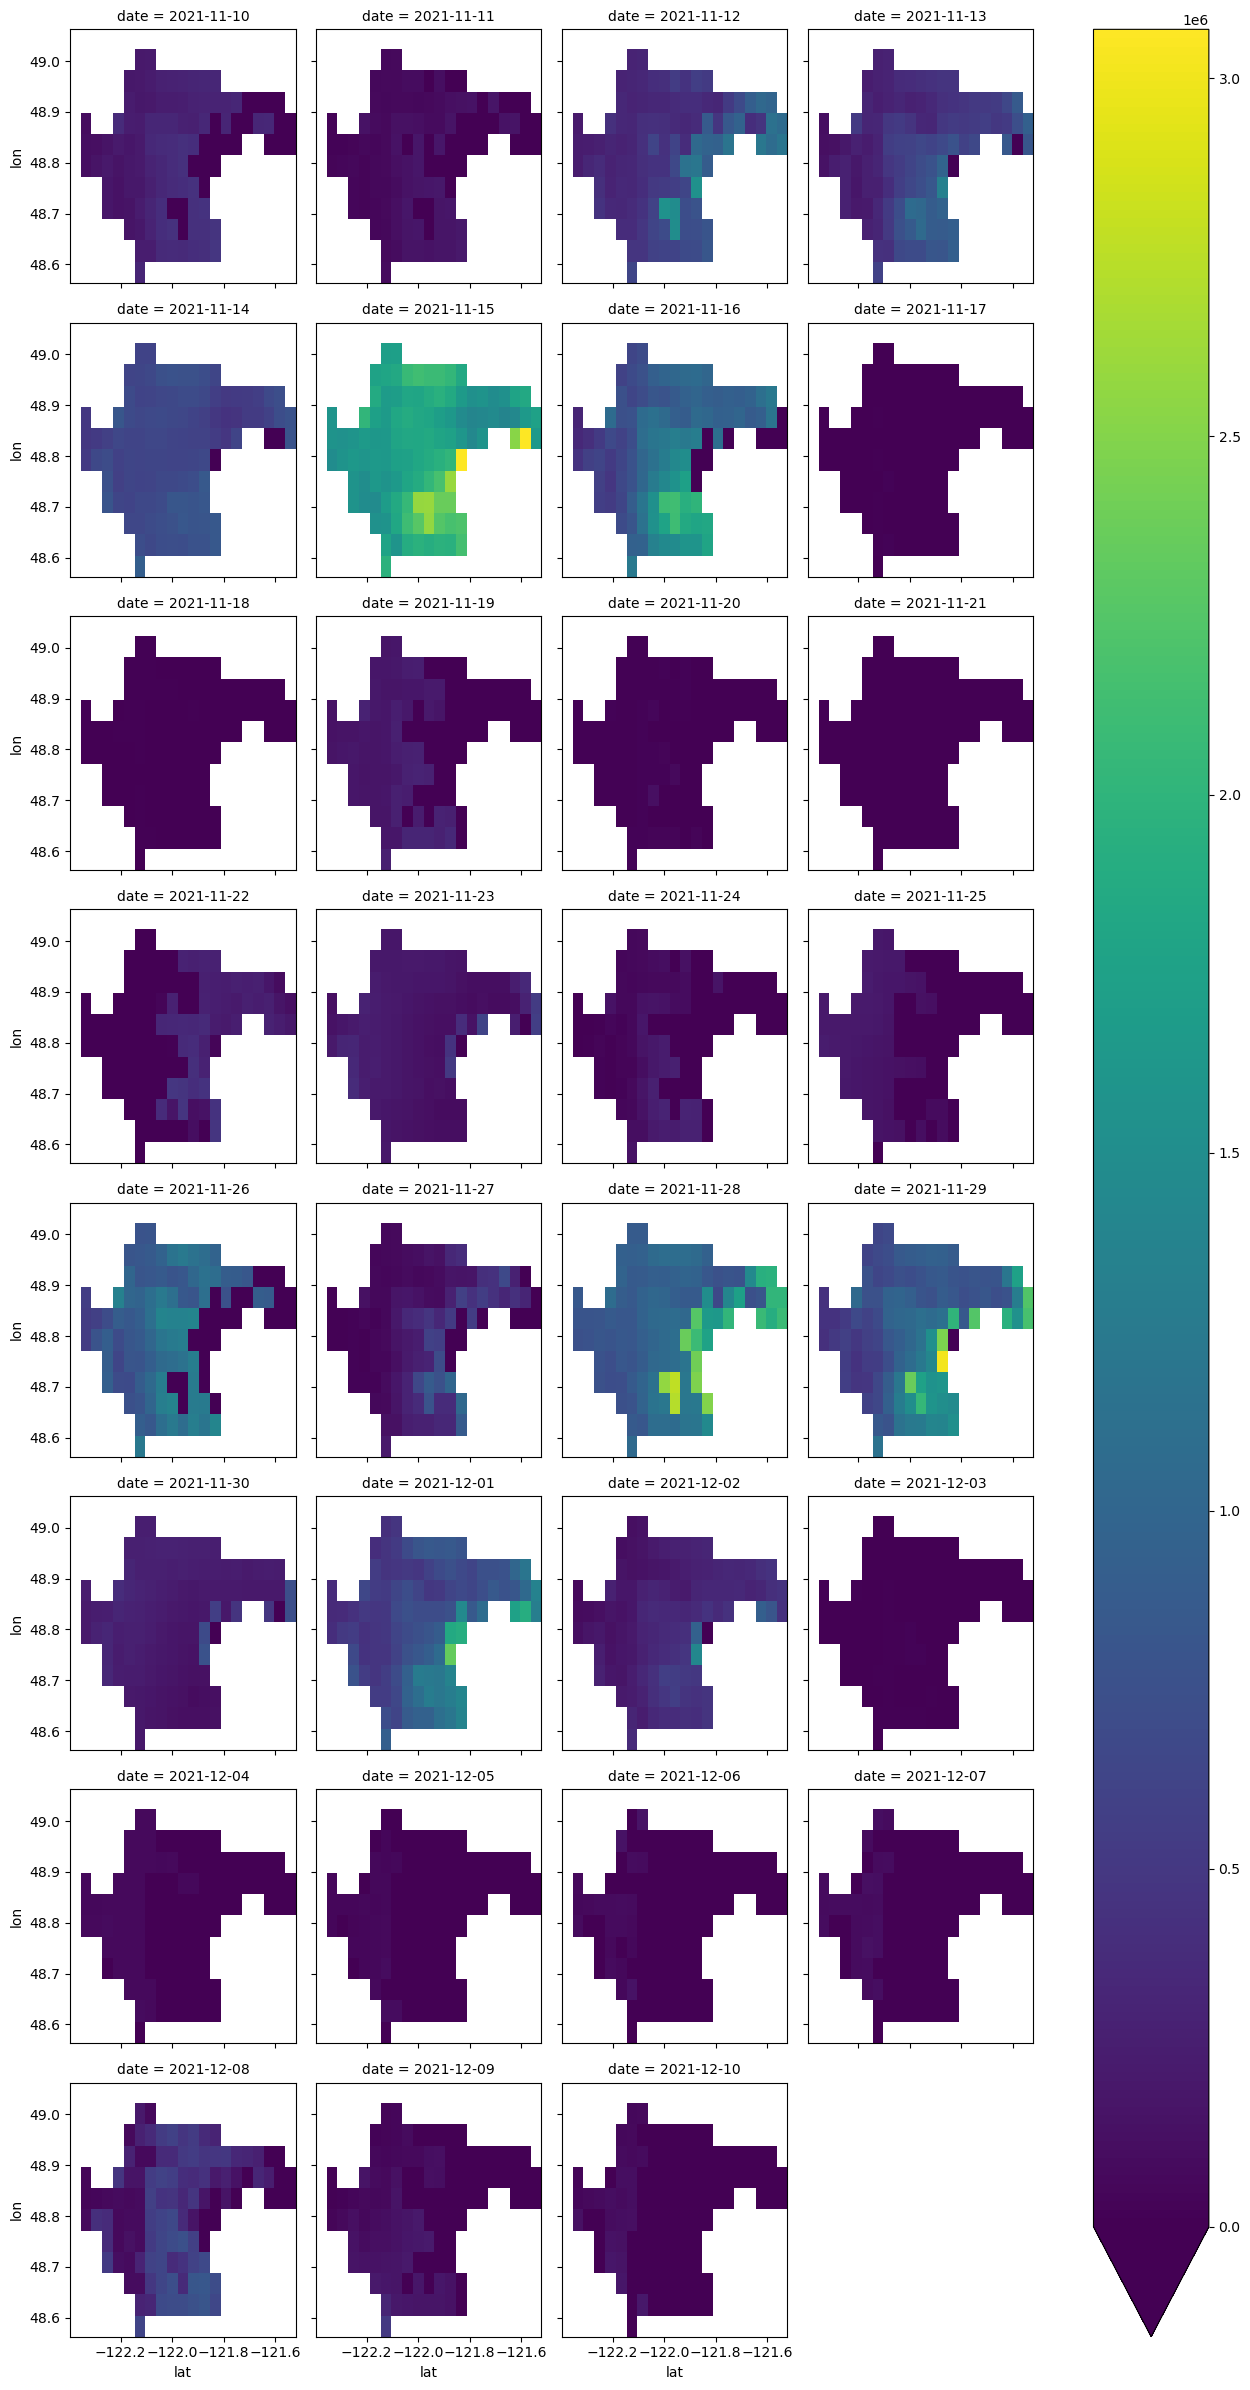

In [5]:
# runoff volume per square = runoff * 10**-3 (converson to m) * prism grid cell size (4kmx4km) 
# gives runoff/cell/day in m3
total_runoff_volume_gridded = total_runoff * (10**-3) * (4000*4000)
total_runoff_volume_gridded.isel(date=slice(0, 31, 1)).plot.imshow(col = 'date', col_wrap = 4, vmin = 0)

In [6]:
# sum across entire watershed
daily_runoff_volume = total_runoff_volume_gridded.sum(dim = ('lat', 'lon'))

In [7]:
# total runoff volume / day
daily_runoff_volume

<xarray.DataArray (date: 31)>
array([2.60922389e+07, 9.23390416e+06, 6.57570350e+07, 5.79638940e+07,
       7.33935779e+07, 2.07389686e+08, 1.09883150e+08, 3.36259208e+05,
       4.65107005e+05, 1.42315363e+07, 1.67589413e+06, 3.22402365e+04,
       1.45087296e+07, 2.21235184e+07, 8.08886909e+06, 9.87649668e+06,
       8.85645027e+07, 2.59634199e+07, 1.33582884e+08, 1.14463107e+08,
       2.80380469e+07, 9.13157740e+07, 3.65923722e+07, 5.45564658e+05,
       3.06306254e+06, 1.76927039e+06, 1.93978853e+06, 2.53072198e+06,
       3.86471865e+07, 8.42535196e+06, 2.85363734e+06])
Coordinates:
  * date     (date) datetime64[ns] 2021-11-10 2021-11-11 ... 2021-12-10

In [8]:
# read in discharge
discharge_df = pd.read_parquet('discharge_data/everson.parquet', engine = 'pyarrow')

In [9]:
discharge_df.head()

,USGS:12211200:00060:00003,USGS:12211200:00060:00003_qualifiers,USGS:12211200:00065:00003,USGS:12211200:00065:00003_qualifiers
datetimeUTC,,,,
2021-11-10 00:00:00+00:00,4850.0,A,75.21,A
2021-11-11 00:00:00+00:00,4520.0,A,75.03,A
2021-11-12 00:00:00+00:00,12500.0,A,78.27,A
2021-11-13 00:00:00+00:00,10900.0,A,77.84,A
2021-11-14 00:00:00+00:00,23000.0,A,81.07,A


In [10]:
# convert daily mean streamflow from cfs to m3/d
daily_discharge_volume = discharge_df['USGS:12211200:00060:00003']*60*60*24/35.314666212661

## Calculate the difference between runoff and streamflow

In [11]:
daily_streamflow_difference = []
daily_streamflow_percent = []

for i in range(len(date_list)):
    # daily volume difference between total runoff and total discharge
    daily_delta = daily_runoff_volume.isel(date=i).values - daily_discharge_volume.iloc[i]
    
    # percent volume difference
    daily_percent = 100*daily_delta/daily_discharge_volume.iloc[i]
    daily_streamflow_difference.append(daily_delta)
    daily_streamflow_percent.append(daily_percent)

## Plot the % difference
Wow! They're super off from each other. Anecdotally from professors, PRISM tends to overestimate precipitation in this region, although this error does seem to be too high. Investigating the snow volume calculations a little bit more, as well as using CO-OP station,  might help me understand where all of this is going wrong. Another thing would be to subtract baseflow from discharge, although that would make this error larger for the most part.

Text(0.5, 1.0, '% Difference between Calculated Runoff and Measured Streamflow')

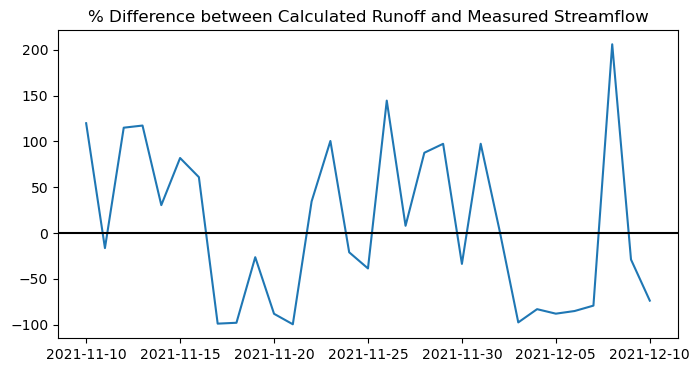

In [12]:
f, a = plt.subplots(figsize = (8, 4))
a.plot(date_list, daily_streamflow_percent)
a.xaxis.set_ticks(date_list[::5])
a.axhline(0, color = 'k')
a.set_title('% Difference between Calculated Runoff and Measured Streamflow')